In [1]:
import pandas as pd
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer
from gensim.models import Word2Vec
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [2]:

df=pd.read_excel('travel_destinations.xlsx')


In [3]:
df.head()  # Display the first few rows of the DataFrame

,City,Country,Category,Best_Time_to_Travel
0,London,United Kingdom,"history, culture, museums, theatre, shopping, ...","Apr, May, Jun, Sep, Oct"
1,Paris,France,"art, museums, landmarks, culture, history, foo...","Apr, May, Jun, Sep, Oct"
2,Rome,Italy,"history, ancient ruins, culture, art, food, re...","Apr, May, Jun, Sep, Oct"
3,Berlin,Germany,"history, culture, nightlife, art, museums, music","May, Jun, Jul, Aug, Sep"
4,Madrid,Spain,"art, museums, nightlife, food, culture, histor...","Apr, May, Jun, Sep, Oct"


In [4]:
print(df['Country'].unique())

['United Kingdom' 'France' 'Italy' 'Germany' 'Spain' 'Czech Republic'
 'Netherlands' 'Greece' 'Portugal' 'Switzerland' 'Iceland' 'Austria'
 'Ireland' 'Denmark' 'Sweden' 'Japan' 'South Korea' 'China' 'Thailand'
 'Singapore' 'Indonesia' 'Vietnam' 'India' 'United Arab Emirates' 'Turkey'
 'USA' 'Canada' 'Mexico' 'Brazil' 'Argentina' 'Peru' 'Chile' 'Colombia'
 'Australia' 'New Zealand' 'Poland' 'Hungary' 'Belgium' 'Norway'
 'Malaysia' 'Nepal' 'Israel' 'Ecuador' 'Sri Lanka' 'Morocco' 'Egypt'
 'Jordan' 'Russia' 'Finland' 'Taiwan' 'Philippines' 'Cambodia' 'Laos'
 'South Africa' 'Kenya' 'Tanzania' 'Cuba' 'Panama' 'Fiji'
 'French Polynesia' 'Croatia' 'Maldives' 'Zambia/Zimbabwe' 'Botswana'
 'Bolivia']


In [5]:
df['Country'] = df['Country'].str.strip()
india_count = (df['Country'] == 'India').sum()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   City                 215 non-null    object
 1   Country              215 non-null    object
 2   Category             215 non-null    object
 3   Best_Time_to_Travel  215 non-null    object
dtypes: object(4)
memory usage: 6.8+ KB


In [ ]:
print(df.isnull().sum())


City                   0
Country                0
Category               0
Best_Time_to_Travel    0
dtype: int64


,City,Country,Category,Best_Time_to_Travel
0,London,United Kingdom,"history, culture, museums, theatre, shopping, ...","Apr, May, Jun, Sep, Oct"
1,Paris,France,"art, museums, landmarks, culture, history, foo...","Apr, May, Jun, Sep, Oct"
2,Rome,Italy,"history, ancient ruins, culture, art, food, re...","Apr, May, Jun, Sep, Oct"
3,Berlin,Germany,"history, culture, nightlife, art, museums, music","May, Jun, Jul, Aug, Sep"
4,Madrid,Spain,"art, museums, nightlife, food, culture, histor...","Apr, May, Jun, Sep, Oct"


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import pickle

country_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('pca', PCA(n_components=5))
])

country_pca = country_transformer.fit_transform(df[['Country']])

for i in range(country_pca.shape[1]):
    df[f'country_pca_{i+1}'] = country_pca[:, i]

df.drop(columns=['Country'], inplace=True)  


with open('country_transformer.pkl', 'wb') as f:
    pickle.dump(country_transformer, f)


In [9]:
df.head()

,City,Category,Best_Time_to_Travel,country_pca_1,country_pca_2,country_pca_3,country_pca_4,country_pca_5
0,London,"history, culture, museums, theatre, shopping, ...","Apr, May, Jun, Sep, Oct",-0.289581,-0.104868,-0.043624,-0.042221,0.000000e+00
1,Paris,"art, museums, landmarks, culture, history, foo...","Apr, May, Jun, Sep, Oct",-0.289581,-0.104868,-0.043624,-0.042221,-1.674422e-16
2,Rome,"history, ancient ruins, culture, art, food, re...","Apr, May, Jun, Sep, Oct",-0.296417,-0.115632,-0.059075,-0.064795,-7.723655e-17
3,Berlin,"history, culture, nightlife, art, museums, music","May, Jun, Jul, Aug, Sep",-0.289581,-0.104868,-0.043624,-0.042221,-1.258088e-16
4,Madrid,"art, museums, nightlife, food, culture, histor...","Apr, May, Jun, Sep, Oct",-0.289581,-0.104868,-0.043624,-0.042221,1.446996e-16


In [10]:
X_features = df.drop(columns=['City'])


In [11]:

from sklearn.base import BaseEstimator, TransformerMixin

class BestTimeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, col="best_time"):
        self.col = col
        self.mlb = MultiLabelBinarizer(classes=list(range(1, 13)))
        self.pca = PCA(n_components=1)

    def fit(self, X, y=None):
        X = X.copy()
        month_lists = [self._months_to_list(s) for s in X[self.col]]
        one_hot = self.mlb.fit_transform(month_lists)
        quarters = self._months_to_quarters(one_hot)
        self.pca.fit(quarters)
        return self

    def transform(self, X):
        X = X.copy()
        month_lists = [self._months_to_list(s) for s in X[self.col]]
        one_hot = self.mlb.transform(month_lists)
        quarters = self._months_to_quarters(one_hot)
        X[self.col] = self.pca.transform(quarters)
        return X

    def _months_to_list(self, s):
        mapping = {"Jan":1, "Feb":2, "Mar":3, "Apr":4, "May":5, "Jun":6,
                   "Jul":7, "Aug":8, "Sep":9, "Oct":10, "Nov":11, "Dec":12}
        return [mapping[m.strip()] for m in s.split(",") if m.strip() in mapping]

    def _months_to_quarters(self, one_hot):
        Q1 = one_hot[:, [0,1,2]].sum(axis=1)
        Q2 = one_hot[:, [3,4,5]].sum(axis=1)
        Q3 = one_hot[:, [6,7,8]].sum(axis=1)
        Q4 = one_hot[:, [9,10,11]].sum(axis=1)
        return np.vstack([Q1, Q2, Q3, Q4]).T




time_transformer = BestTimeTransformer(col="Best_Time_to_Travel")

# Fit and transform in one go, updating df
X_features = time_transformer.fit_transform(X_features)

# Save transformer
with open('time_transformer.pkl', 'wb') as f:
    pickle.dump(time_transformer, f)


In [14]:
X_features.head()  

,Category,Best_Time_to_Travel,country_pca_1,country_pca_2,country_pca_3,country_pca_4,country_pca_5
0,"history, culture, museums, theatre, shopping, ...",-1.806055,-0.289581,-0.104868,-0.043624,-0.042221,0.000000e+00
1,"art, museums, landmarks, culture, history, foo...",-1.806055,-0.289581,-0.104868,-0.043624,-0.042221,-1.674422e-16
2,"history, ancient ruins, culture, art, food, re...",-1.806055,-0.296417,-0.115632,-0.059075,-0.064795,-7.723655e-17
3,"history, culture, nightlife, art, museums, music",-2.833006,-0.289581,-0.104868,-0.043624,-0.042221,-1.258088e-16
4,"art, museums, nightlife, food, culture, histor...",-1.806055,-0.289581,-0.104868,-0.043624,-0.042221,1.446996e-16


In [15]:
def preprocess(text):
    text = text.lower()  
    text = re.sub(r'[,\(\)]', ' ', text)
    tokens = text.split()
    return tokens

In [16]:
X_features['tokens'] = X_features['Category'].apply(preprocess)
X_features.drop(columns=['Category'], inplace=True)


In [17]:
X_features.head()  

,Best_Time_to_Travel,country_pca_1,country_pca_2,country_pca_3,country_pca_4,country_pca_5,tokens
0,-1.806055,-0.289581,-0.104868,-0.043624,-0.042221,0.000000e+00,"[history, culture, museums, theatre, shopping,..."
1,-1.806055,-0.289581,-0.104868,-0.043624,-0.042221,-1.674422e-16,"[art, museums, landmarks, culture, history, fo..."
2,-1.806055,-0.296417,-0.115632,-0.059075,-0.064795,-7.723655e-17,"[history, ancient, ruins, culture, art, food, ..."
3,-2.833006,-0.289581,-0.104868,-0.043624,-0.042221,-1.258088e-16,"[history, culture, nightlife, art, museums, mu..."
4,-1.806055,-0.289581,-0.104868,-0.043624,-0.042221,1.446996e-16,"[art, museums, nightlife, food, culture, histo..."


In [19]:
X_features.rename(columns={"Best_Time_to_Travel": "visit_time"}, inplace=True)


In [21]:
import gensim.downloader as api

# This will download the model (the first time you run it). 
# It may take a few minutes.
print("Loading pre-trained GloVe model...")
glove_model = api.load('glove-wiki-gigaword-50')  # smallest is 50, no 30 available
print("Model loaded successfully!")

Loading pre-trained GloVe model...
Model loaded successfully!


In [22]:
def tokens_to_vector(tokens, model, vector_size=100):
    vectors = [model[word] for word in tokens if word in model]
    if not vectors:  # If no words are in vocab
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

In [ ]:
token_vectors = X_features['tokens'].apply(lambda x: tokens_to_vector(x, glove_model, 50))

In [24]:
vectors_df = pd.DataFrame(token_vectors.tolist(), index=X_features.index)
final_df = pd.concat([X_features.drop(columns=['tokens']), vectors_df], axis=1)

In [25]:

final_df.head()

,visit_time,country_pca_1,country_pca_2,country_pca_3,country_pca_4,country_pca_5,0,1,2,3,...,40,41,42,43,44,45,46,47,48,49
0,-1.806055,-0.289581,-0.104868,-0.043624,-0.042221,0.000000e+00,0.131828,0.799387,-0.918181,0.118027,...,-0.163140,0.080440,0.250302,0.381431,-0.311058,0.292825,-0.434772,-0.357039,0.058890,-0.266678
1,-1.806055,-0.289581,-0.104868,-0.043624,-0.042221,-1.674422e-16,0.098418,0.740478,-0.961638,0.103041,...,-0.097328,0.103363,0.395217,0.286318,0.124218,0.495602,-0.211896,-0.268275,0.197212,-0.241438
2,-1.806055,-0.296417,-0.115632,-0.059075,-0.064795,-7.723655e-17,0.027173,0.792330,-0.894934,-0.008606,...,-0.125505,-0.190878,0.445123,0.547811,0.195213,0.738503,-0.251238,-0.186158,-0.000080,-0.917306
3,-2.833006,-0.289581,-0.104868,-0.043624,-0.042221,-1.258088e-16,-0.413253,0.808456,-1.207943,0.056256,...,0.057457,0.072563,0.225785,0.243978,-0.054247,0.492383,-0.144160,-0.328072,-0.260362,-0.194875
4,-1.806055,-0.289581,-0.104868,-0.043624,-0.042221,1.446996e-16,0.011297,0.593843,-0.984343,0.059265,...,-0.044694,0.126511,0.360531,0.363442,0.220637,0.486656,-0.297851,-0.218123,0.191839,-0.141318


In [26]:
final_df.columns = final_df.columns.astype(str)

X = final_df

scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns  
)

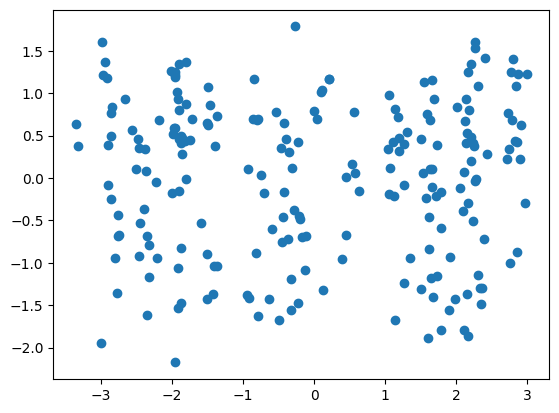

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# assume X is your numerical dataframe
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

plt.scatter(X_reduced[:,0], X_reduced[:,1])
plt.show()


In [28]:
k = 25
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add results directly to original raw df
results_df = df.assign(Cluster=clusters)

c:\Users\OMEN\anaconda3\envs\gensim-env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [29]:
results_df.head()

,City,Category,Best_Time_to_Travel,country_pca_1,country_pca_2,country_pca_3,country_pca_4,country_pca_5,Cluster
0,London,"history, culture, museums, theatre, shopping, ...","Apr, May, Jun, Sep, Oct",-0.289581,-0.104868,-0.043624,-0.042221,0.000000e+00,19
1,Paris,"art, museums, landmarks, culture, history, foo...","Apr, May, Jun, Sep, Oct",-0.289581,-0.104868,-0.043624,-0.042221,-1.674422e-16,19
2,Rome,"history, ancient ruins, culture, art, food, re...","Apr, May, Jun, Sep, Oct",-0.296417,-0.115632,-0.059075,-0.064795,-7.723655e-17,19
3,Berlin,"history, culture, nightlife, art, museums, music","May, Jun, Jul, Aug, Sep",-0.289581,-0.104868,-0.043624,-0.042221,-1.258088e-16,4
4,Madrid,"art, museums, nightlife, food, culture, histor...","Apr, May, Jun, Sep, Oct",-0.289581,-0.104868,-0.043624,-0.042221,1.446996e-16,19


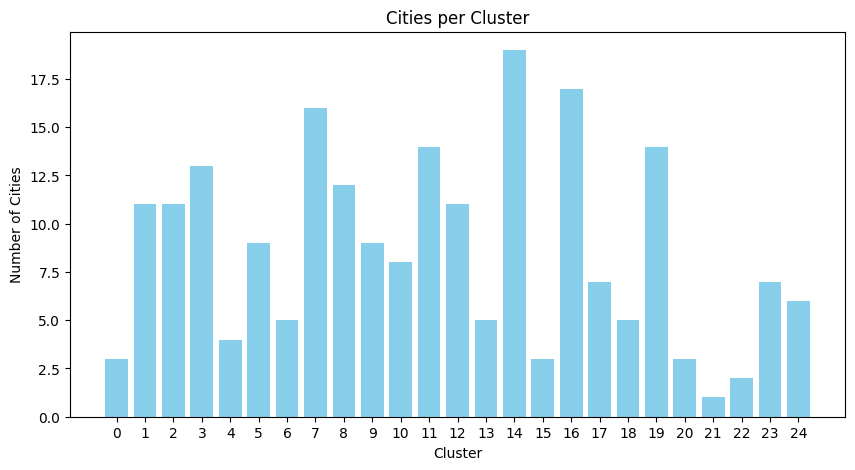

In [31]:
results_df['Cluster'].value_counts().sort_index()
cluster_counts = pd.Series(results_df['Cluster']).value_counts().sort_index()

plt.figure(figsize=(10,5))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Number of Cities')
plt.title('Cities per Cluster')
plt.xticks(cluster_counts.index)
plt.show()

In [34]:
# for cluster_id in sorted(final_df3['Cluster'].unique()):
#     print(f"\nCluster {cluster_id}:")
#     cluster_cities = final_df3.loc[final_df3['Cluster'] == cluster_id, 'City']
#     print(cluster_cities.tolist())
# print(len(country_cols))
results_df.columns

Index(['City', 'Category', 'Best_Time_to_Travel', 'country_pca_1',
       'country_pca_2', 'country_pca_3', 'country_pca_4', 'country_pca_5',
       'Cluster'],
      dtype='object')

In [38]:
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


with open("glove_vectors.pkl", "wb") as f:
    pickle.dump(glove_model, f)


with open("kmeans.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [40]:

final_df.to_pickle("final_df.pkl")

results_df.to_pickle("results_df.pkl")

glove_model.save("glove_vectors.gensim")

for file in ["country_transformer.pkl", "time_transformer.pkl", "scaler.pkl", "kmeans.pkl"]:
    try:
        with open(file, "rb") as f:
            pickle.load(f)
        print(f"✅ {file} verified.")
    except Exception as e:
        print(f"❌ Error with {file}: {e}")


✅ country_transformer.pkl verified.
✅ time_transformer.pkl verified.
✅ scaler.pkl verified.
✅ kmeans.pkl verified.


In [41]:
def print_cluster_details(cluster_num):
    cluster_cities = results_df[results_df['Cluster'] == cluster_num]
    print(f"Cluster {cluster_num} Cities:")
    for _, row in cluster_cities.iterrows():
        print(f"- {row['City']}: Tokens: {row['Category']}, Best Time: {row['Best_Time_to_Travel']}")

print_cluster_details(3)


Cluster 3 Cities:
- Tokyo: Tokens: culture, food, technology, shopping, temples, shrines, nightlife, pop culture, Best Time: Mar, Apr, May, Oct, Nov
- Seoul: Tokens: culture, food, K-pop, shopping, history, palaces, nightlife, technology, Best Time: Apr, May, Sep, Oct
- Hong Kong: Tokens: skyline, shopping, food, dim sum, hiking, finance, culture, Best Time: Oct, Nov, Dec, Jan, Feb, Mar, Apr
- Bangkok: Tokens: culture, temples, food, street markets, nightlife, shopping, canals, Best Time: Nov, Dec, Jan, Feb
- Singapore: Tokens: food, shopping, gardens, modern architecture, culture (mix), family-friendly, Best Time: Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct (relatively consistent)
- Istanbul: Tokens: history, culture, mosques, bazaars, food, architecture (East meets West), Best Time: Apr, May, Jun, Sep, Oct
- Osaka: Tokens: food (street food), nightlife, modern culture, castle, shopping (Dotonbori), Best Time: Mar, Apr, May, Oct, Nov
- Busan: Tokens: beach, port city, seafood markets,

In [36]:
import numpy as np
import pandas as pd

# Map months to quarters
QUARTERS = {
    "Q1": {"Jan","Feb","Mar"},
    "Q2": {"Apr","May","Jun"},
    "Q3": {"Jul","Aug","Sep"},
    "Q4": {"Oct","Nov","Dec"},
}

def parse_months_to_quarters(best_time_str: str):
    months = [m.strip()[:3].title() for m in best_time_str.split(",") if m.strip()]
    q1 = int(any(m in QUARTERS["Q1"] for m in months))
    q2 = int(any(m in QUARTERS["Q2"] for m in months))
    q3 = int(any(m in QUARTERS["Q3"] for m in months))
    q4 = int(any(m in QUARTERS["Q4"] for m in months))
    return [q1, q2, q3, q4]

def tokens_to_vec(tokens_str: str, model, dim: int):
    toks = [t.strip().lower() for t in tokens_str.split(",") if t.strip()]
    vecs = [model[w] for w in toks if w in model.key_to_index]
    if vecs:
        return np.mean(vecs, axis=0)
    return np.zeros(dim, dtype=float)


In [37]:
def build_new_city_row(city:str, country:str, best_time:str, tokens:str,
                       COUNTRY_DUMMY_COLS, pca_country, pca_months,
                       glove_model, feature_cols_order):
    # --- Country OHE vector in the SAME column space/order as training ---
    country_ohe = np.zeros(len(COUNTRY_DUMMY_COLS), dtype=float)
    col_name = f"Country_{country}"
    if col_name in COUNTRY_DUMMY_COLS:
        country_ohe[COUNTRY_DUMMY_COLS.index(col_name)] = 1.0
    # PCA -> 5 dims
    country_pca = pca_country.transform([country_ohe]).ravel()  # shape (5,)

    # --- visit_time (PCA of Q1..Q4) ---
    q_flags = parse_months_to_quarters(best_time)               # [q1,q2,q3,q4]
    visit_time = float(pca_months.transform([q_flags]).ravel()[0])

    # --- token embedding (e.g., 50 dims) ---
    dim = glove_model.vector_size
    tok_vec = tokens_to_vec(tokens, glove_model, dim)           # shape (dim,)

    # --- Assemble into your final_df schema ---
    feat = {f"Country_PCA_{i+1}": country_pca[i] for i in range(5)}
    feat["visit_time"] = visit_time
    for i in range(len(tok_vec)):
        feat[str(i)] = float(tok_vec[i])  # columns "0".."49"

    row = pd.DataFrame([feat])
    # Reorder columns EXACTLY like training
    row = row.reindex(columns=[str(c) for c in feature_cols_order], fill_value=0.0)
    return row


In [38]:
def predict_new_city(city:str, country:str, best_time:str, tokens:str,
                     COUNTRY_DUMMY_COLS, pca_country, pca_months,
                     glove_model, scaler, kmeans, feature_cols_order,
                     catalog_df):
    # Build feature row
    new_row = build_new_city_row(city, country, best_time, tokens,
                                 COUNTRY_DUMMY_COLS, pca_country, pca_months,
                                 glove_model, feature_cols_order)

    # Scale & predict
    new_scaled = scaler.transform(new_row)
    cluster = int(kmeans.predict(new_scaled)[0])

    # Similar cities from your catalog
    similar = (
        catalog_df.loc[catalog_df["Cluster"] == cluster, ["City","Country"]]
        .sort_values(["Country","City"])
        .reset_index(drop=True) 
    )

    return {"city": city,
            "country": country,
            "predicted_cluster": cluster,
            "similar_cities": similar}

feature_cols_order = final_df.columns.astype(str).tolist()


In [39]:
# Artifacts from training (you should already have these)
# COUNTRY_DUMMY_COLS = [f"Country_{c}" for c in sorted(df['Country'].unique())]
# pca_country, pca_months, glove_model, scaler, kmeans already fitted
# feature_cols_order = final_df.columns.astype(str).tolist()
# catalog_df = readable df with ['City','Country','Cluster']

res = predict_new_city(
    city="Rishikesh",
    country="India",
    best_time="Feb, Mar, Sep, Oct",
    tokens="history",
    COUNTRY_DUMMY_COLS=country_cols,
    pca_country=pca,
    pca_months=pca_months,
    glove_model=glove_model,
    scaler=scaler,
    kmeans=kmeans,
    feature_cols_order=feature_cols_order,
    catalog_df=final_df3
)

print("Predicted cluster:", res["predicted_cluster"])
print(res["similar_cities"].head(10))


c:\Users\OMEN\anaconda3\envs\gensim-env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


ValueError: X has 65 features, but PCA is expecting 56 features as input.

NameError: name 'scaler' is not defined